<a href="https://colab.research.google.com/github/muhkartal/Sentiment-Analysis/blob/main/DarkCircles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install opencv-contrib-python-headless==4.8.0.74
!pip install numpy==1.24.3

!pip install --upgrade --force-reinstall mediapipe==0.10.5


  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
te

  Using cached mediapipe-0.10.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached matplotlib-3.10.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached sounddevice-0.5.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached cffi-1.17.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached contourpy-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0

In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

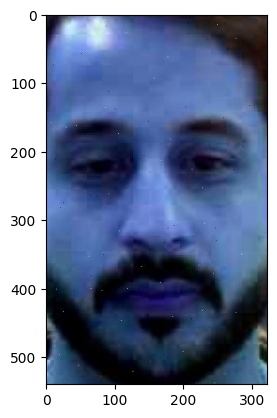

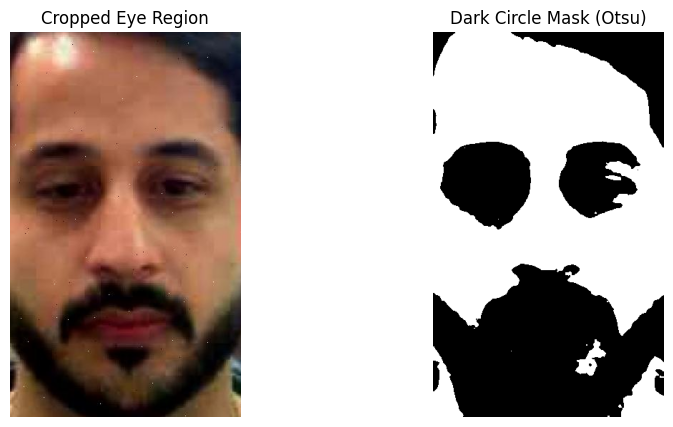

In [31]:
EYE_LANDMARK_INDICES = [
    33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7, # Left eye outer contour
    263, 466, 388, 387, 386, 385, 384, 398, 362, 380, 379, 378, 377, 374, 373, 283 # Right eye outer contour
]
mp_face_mesh = mp.solutions.face_mesh

def get_landmark_coords(image, landmarks, indexes):

    h, w = image.shape[:2]

    valid_indexes = [i for i in indexes if i is not None and 0 <= i < len(landmarks)]
    return np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in valid_indexes], np.int32)

def detect_landmarks(image):

    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]
            return landmarks
    return []

def detect_dark_circles_otsu(image_path):

    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not read image file at path: {image_path}")
        return None, None


    landmarks = detect_landmarks(image)


    if not landmarks: # Check if landmarks were successfully detected and returned
        print(f"No face detected or landmarks found in {image_path}.")
        return None, None


    face_landmarks = landmarks.landmark
    h_orig, w_orig = image.shape[:2]


    eye_pts = get_landmark_coords(image, face_landmarks, EYE_LANDMARK_INDICES)

    if eye_pts.size == 0:
        print(f"Could not get valid eye landmark coordinates in {image_path}.")
        return None, None



    x_min = np.min(eye_pts[:, 0])
    y_min = np.min(eye_pts[:, 1])
    x_max = np.max(eye_pts[:, 0])
    y_max = np.max(eye_pts[:, 1])


    buffer_x = int((x_max - x_min) * 0.2)
    buffer_y_top = int((y_max - y_min) * 0.5)
    buffer_y_bottom = int((y_max - y_min) * 1.0)


    x_min = max(0, x_min - buffer_x)
    y_min = max(0, y_min - buffer_y_top)
    x_max = min(w_orig, x_max + buffer_x)
    y_max = min(h_orig, y_max + buffer_y_bottom)


    if x_max <= x_min or y_max <= y_min:
         print(f"Invalid bounding box calculated for eye region in {image_path}.")
         return None, None


    cropped_eye_region = image[y_min:y_max, x_min:x_max]
    plt.imshow(cropped_eye_region)
    plt.show()


    if cropped_eye_region.shape[0] == 0 or cropped_eye_region.shape[1] == 0:
        print(f"Cropped eye region is empty for {image_path}.")
        return None, None



    gray_eye_region = cv2.cvtColor(cropped_eye_region, cv2.COLOR_BGR2GRAY)


    blurred_eye_region = cv2.GaussianBlur(gray_eye_region, (5, 5), 0)


    ret, dark_circle_mask = cv2.threshold(blurred_eye_region, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    return cropped_eye_region, dark_circle_mask


sample_image_for_dark_circles = "/content/drive/MyDrive/Content/face.jpg" # Replace with a real path

cropped_eye, dark_circle_mask = detect_dark_circles_otsu(sample_image_for_dark_circles)

if cropped_eye is not None and dark_circle_mask is not None:

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)

    plt.imshow(cv2.cvtColor(cropped_eye, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Eye Region')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(dark_circle_mask, cmap='gray')
    plt.title('Dark Circle Mask (Otsu)')
    plt.axis('off')

    plt.show()
else:
    print("Could not process the image for dark circle detection.")

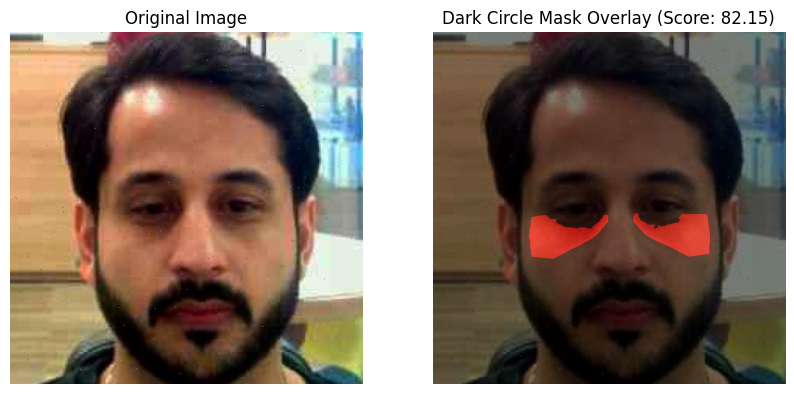

Calculated Dark Circle Score: 82.15


In [34]:

LEFT_EYE_IDXS = [
    35, 226, 25, 110, 24, 23, 154, 243, 112, 243, 244, 245, 188, 114, 47, 100, 101, 50, 123, 116, 143]  # Left eye outer contour4

RIGHT_EYE_IDXS = [
    463, 464, 465, 412, 343, 277, 329, 330, 280, 352, 345, 372, 255, 339, 254, 253, 381# Right eye outer contour
]



mp_face_mesh = mp.solutions.face_mesh

def get_landmark_coords(image, landmarks, indexes):
    h, w = image.shape[:2]
    valid_indexes = [i for i in indexes if i is not None and 0 <= i < len(landmarks)]
    return np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in valid_indexes], np.int32)




def different_zones(image, landmarks):
    h, w = image.shape[:2]

    left_eye_pts = get_landmark_coords(image, landmarks.landmark, LEFT_EYE_IDXS)
    right_eye_pts = get_landmark_coords(image, landmarks.landmark, RIGHT_EYE_IDXS)

    left_eye_mask_full = np.zeros((h, w), dtype=np.uint8)
    right_eye_mask_full = np.zeros((h, w), dtype=np.uint8)


    if left_eye_pts.size > 0:
        cv2.fillPoly(left_eye_mask_full, [np.array(left_eye_pts, dtype=np.int32)], 255)
    if right_eye_pts.size > 0:
        cv2.fillPoly(right_eye_mask_full, [np.array(right_eye_pts, dtype=np.int32)], 255)

    left_eye_segment = cv2.bitwise_and(image, image, mask=left_eye_mask_full)
    right_eye_segment = cv2.bitwise_and(image, image, mask=right_eye_mask_full)

    return left_eye_segment, right_eye_segment, left_eye_mask_full, right_eye_mask_full

def apply_clahe(image_gray):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(image_gray)

def detect_dark_circles_otsu(image_path):

    original_image = cv2.imread(image_path)

    if original_image is None:
        print(f"Error: Could not read image file at path: {image_path}")
        return None, None, None


    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    h_orig, w_orig = original_image.shape[:2]


    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(rgb_image)

    if not results.multi_face_landmarks:
        print(f"No face detected in {image_path}.")
        return original_image, np.zeros((h_orig, w_orig), dtype=np.uint8), 0.0

    landmarks = results.multi_face_landmarks[0]


    left_segment, right_segment, left_eye_mask_full, right_eye_mask_full = different_zones(original_image, landmarks)


    left_dark_circle_mask_full_size = np.zeros((h_orig, w_orig), dtype=np.uint8)
    right_dark_circle_mask_full_size = np.zeros((h_orig, w_orig), dtype=np.uint8)



    if left_segment.shape[0] > 0 and left_segment.shape[1] > 0 and np.max(left_segment) > 0:
        gray_left_eye = cv2.cvtColor(left_segment, cv2.COLOR_BGR2GRAY)
        gray_left_eye = apply_clahe(gray_left_eye)


        ksize = (7, 7)
        if gray_left_eye.shape[0] >= ksize[0] and gray_left_eye.shape[1] >= ksize[1]:
             blurred_left_eye = cv2.GaussianBlur(gray_left_eye, ksize, 0)
        else:
             print(f"Left eye segment size too small for blur kernel {ksize} in {image_path}.")
             blurred_left_eye = gray_left_eye

        try:

             ret_left, thresh_left = cv2.threshold(blurred_left_eye, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

             left_dark_circle_mask_full_size = thresh_left
        except cv2.error as e:
            print(f"Error during left eye thresholding for {image_path}: {e}")


    if right_segment.shape[0] > 0 and right_segment.shape[1] > 0 and np.max(right_segment) > 0:
        gray_right_eye = cv2.cvtColor(right_segment, cv2.COLOR_BGR2GRAY)
        gray_right_eye = apply_clahe(gray_right_eye)


        ksize = (7, 7)
        if gray_right_eye.shape[0] >= ksize[0] and gray_right_eye.shape[1] >= ksize[1]:
             blurred_right_eye = cv2.GaussianBlur(gray_right_eye, ksize, 0)
        else:
             print(f"Right eye segment size too small for blur kernel {ksize} in {image_path}.")
             blurred_right_eye = gray_right_eye

        try:

             ret_right, thresh_right = cv2.threshold(blurred_right_eye, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

             right_dark_circle_mask_full_size = thresh_right #
        except cv2.error as e:
            print(f"Error during right eye thresholding for {image_path}: {e}")



    combined_dark_circle_mask_full_size = cv2.bitwise_or(left_dark_circle_mask_full_size, right_dark_circle_mask_full_size)


    kernel = np.ones((3, 3), np.uint8)
    combined_dark_circle_mask_full_size = cv2.morphologyEx(combined_dark_circle_mask_full_size, cv2.MORPH_OPEN, kernel) # Opening to remove small objects


    kernel_erode = np.ones((3, 3), np.uint8)
    combined_dark_circle_mask = cv2.erode(combined_dark_circle_mask_full_size, kernel_erode, iterations=1)


    total_eye_region_mask = cv2.bitwise_or(left_eye_mask_full, right_eye_mask_full)
    total_eye_pixel_count = np.sum(total_eye_region_mask > 0)


    kernel_inner = np.ones((5, 5), np.uint8)
    inner_eye_mask = cv2.erode(total_eye_region_mask, kernel_inner, iterations=1)


    dark_pixels_mask = (combined_dark_circle_mask == 0) & (inner_eye_mask > 0)

    dark_circle_pixel_count = np.sum((combined_dark_circle_mask_full_size > 0))

    dark_circle_score = 0.0
    if total_eye_pixel_count > 0:
        dark_circle_score = (dark_circle_pixel_count / total_eye_pixel_count) * 100 # Score as percentage of eye area



    return original_image, combined_dark_circle_mask_full_size, dark_circle_score, dark_pixels_mask



sample_image_for_dark_circles = "/content/drive/MyDrive/Content/face.jpg"

original_img, dark_circle_mask, score, dark_pixels_mask1 = detect_dark_circles_otsu(sample_image_for_dark_circles)

if original_img is not None and dark_circle_mask is not None:

    plt.figure(figsize=(10, 5))


    plt.subplot(1, 2, 1)

    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')


    plt.subplot(1, 2, 2)

    overlay = np.zeros_like(original_img, dtype=np.uint8)

    overlay[dark_circle_mask > 0] = [0, 0, 255]


    alpha = 0.5
    overlaid_image = cv2.addWeighted(original_img, 1 - alpha, overlay, alpha, 0)

    plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Dark Circle Mask Overlay (Score: {score:.2f})')
    plt.axis('off')

    plt.show()
    print(f"Calculated Dark Circle Score: {score:.2f}")

else:
    print("Could not process the image for dark circle detection.")

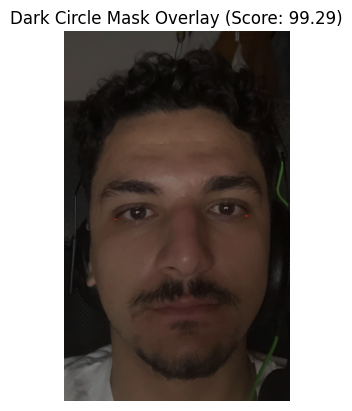

In [28]:


overlay = np.zeros_like(original_img, dtype=np.uint8)



overlay[dark_pixels_mask1] = [0, 0, 255]


alpha = 0.5
overlaid_image = cv2.addWeighted(original_img, 1 - alpha, overlay, alpha, 0)

plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
plt.title(f'Dark Circle Mask Overlay (Score: {score:.2f})')
plt.axis('off')
plt.show()

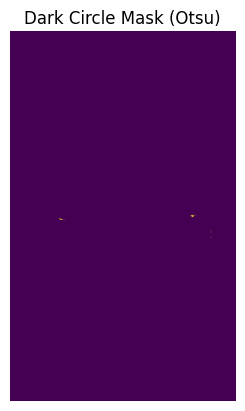

In [29]:

plt.imshow(dark_pixels_mask1)
plt.title('Dark Circle Mask (Otsu)')
plt.axis('off')
plt.show()